In [12]:
%matplotlib inline

from math import ceil
from math import floor
from typing import Tuple
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from einops import repeat
from torch.nn import functional as F

from viv1t import data
from viv1t.utils import plot

plot.set_font()

FONTSIZE = 8
FPS = 30
DPI = 180
COLORMAP = "turbo"

DATA_DIR = Path("../data/sensorium")
H, W = 36, 64

In [13]:
def load_frame(mouse_id: str, trial_id: str | int, t: int = 0):
    mouse_dir = DATA_DIR / data.MOUSE_IDS[mouse_id]
    sample = data.load_trial(mouse_dir, trial_id=trial_id)
    frame = sample["video"][0, t]
    return frame


def set_spine(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("red")
        spine.set_linewidth(2)


def unfold_size(dim: int, patch_size: int, stride: int):
    return floor(((dim - patch_size) / stride) + 1)


def pad_size(dim: int, patch_size: int, stride: int):
    return (ceil(dim / stride) - 1) * stride + patch_size - dim


def zero_pad(frame: torch.Tensor, patch_size: int, stride: int):
    h_pad = pad_size(H, patch_size, stride)
    w_pad = pad_size(W, patch_size, stride)
    padding = (
        w_pad // 2,  # padding left
        w_pad - w_pad // 2,  # padding right
        h_pad // 2,  # padding top
        h_pad - h_pad // 2,  # padding bottom
    )
    print(f"pad: {padding}, frame shape: {frame.shape}")
    frame = rearrange(frame, "h w -> 1 h w")
    frame = F.pad(frame, pad=padding, mode="constant", value=0)
    # frame = F.pad(frame, pad=padding, mode="replicate")
    print(f"pad frame shape: {frame.shape}")
    frame = frame[0]
    return frame, padding


def unfold(frame: np.ndarray, patch_size: int, stride: int, pad: bool):
    frame = torch.from_numpy(frame)
    padding = None
    if pad:
        frame, padding = zero_pad(frame, patch_size, stride=stride)
    patches = frame.unfold(0, patch_size, stride).unfold(1, patch_size, stride)
    shape = patches.shape
    patches = rearrange(patches, "nh nw ph pw -> (nh nw) ph pw")
    patches = patches.numpy()
    return patches, shape, padding


def dropout(patches: np.ndarray, shape: Tuple[int, ...], p: float = 0.0):
    patches = torch.from_numpy(patches)
    patches = rearrange(patches, "n ph pw -> 1 n (ph pw)")
    patches = F.dropout(patches, p=p, training=True)
    patches = patches * (1 - p)  # dropout layer in PyTorch scale the output by 1/(1-p)
    patches = rearrange(patches, "1 n (ph pw) -> n ph pw", ph=shape[2], pw=shape[3])
    patches = patches.numpy()
    return patches


def dropout1d(patches: np.ndarray, shape: Tuple[int, ...], p: float = 0.0):
    patches = torch.from_numpy(patches)
    patches = rearrange(patches, "n ph pw -> 1 n (ph pw)")
    patches = F.dropout1d(patches, p=p, training=True)
    patches = patches * (1 - p)  # dropout layer in PyTorch scale the output by 1/(1-p)
    patches = rearrange(patches, "1 n (ph pw) -> n ph pw", ph=shape[2], pw=shape[3])
    patches = patches.numpy()
    return patches


def plot_patches(
    patches: np.ndarray,
    shape: tuple[int, int],
    title: str,
    cmap: str = "gray",
):
    nrows, ncols = shape[0], shape[1]
    figure, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(6, 4),
        gridspec_kw={"wspace": 0.2, "hspace": -0.1},
        facecolor="aquamarine",
        dpi=DPI,
    )
    axes = axes.ravel()
    for i in range(len(axes)):
        axes[i].imshow(patches[i], aspect="equal", cmap=cmap, vmin=0, vmax=1)
        axes[i].axis("off")
    top = axes[0].get_position()
    figure.text(
        x=0.5,
        y=top.y1 + 0.01,
        s=title,
        fontsize=FONTSIZE,
        ha="center",
    )
    plt.show()
    plt.close(figure)


def visualize_unfold(
    mouse_id: str,
    trial_id: str | int,
    patch_size: int = 7,
    stride: int = 2,
    p: float = 0.05,
):
    frame = load_frame(mouse_id, trial_id, t=25)
    frame = frame / np.max(frame)

    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(frame, cmap="gray")
    ax.axis("off")
    plt.show()
    plt.close(figure)

    unfold_patches, shape, _ = unfold(
        frame, patch_size=patch_size, stride=stride, pad=False
    )
    plot_patches(unfold_patches, shape, title=f"unfold patches {shape} (no padding)")

    unfold_patches, shape, _ = unfold(
        frame, patch_size=patch_size, stride=stride, pad=True
    )
    plot_patches(unfold_patches, shape, title=f"unfold patches {shape} (with padding)")

    # dropout_patches = dropout(unfold_patches, shape, p=p)
    # plot_patches(dropout_patches, shape, title=f"dropout patches {shape} (p={p})")

    dropout1d_patches = dropout1d(unfold_patches, shape, p=p)
    plot_patches(dropout1d_patches, shape, title=f"dropout1d patches {shape} (p={p})")

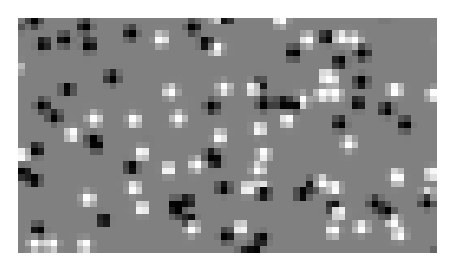

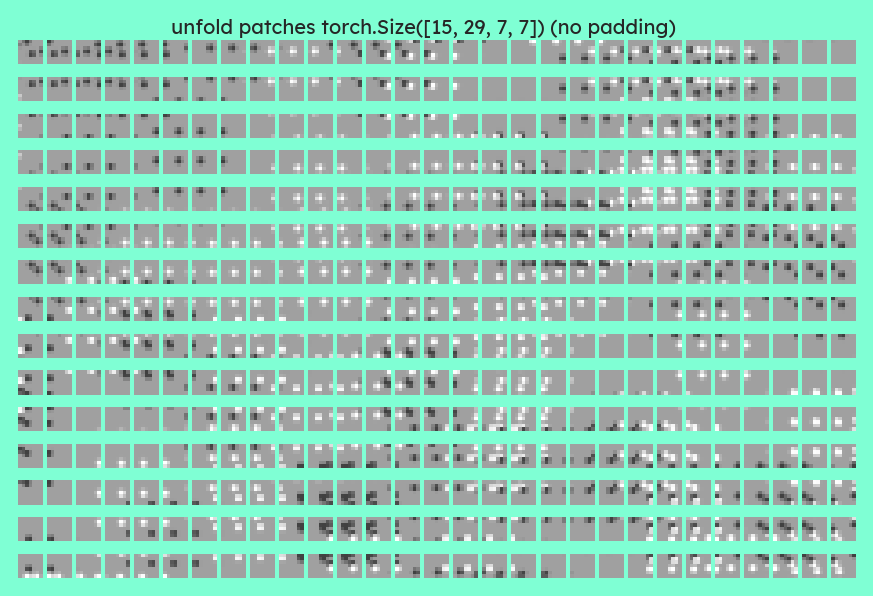

pad: (2, 3, 2, 3), frame shape: torch.Size([36, 64])
pad frame shape: torch.Size([1, 41, 69])


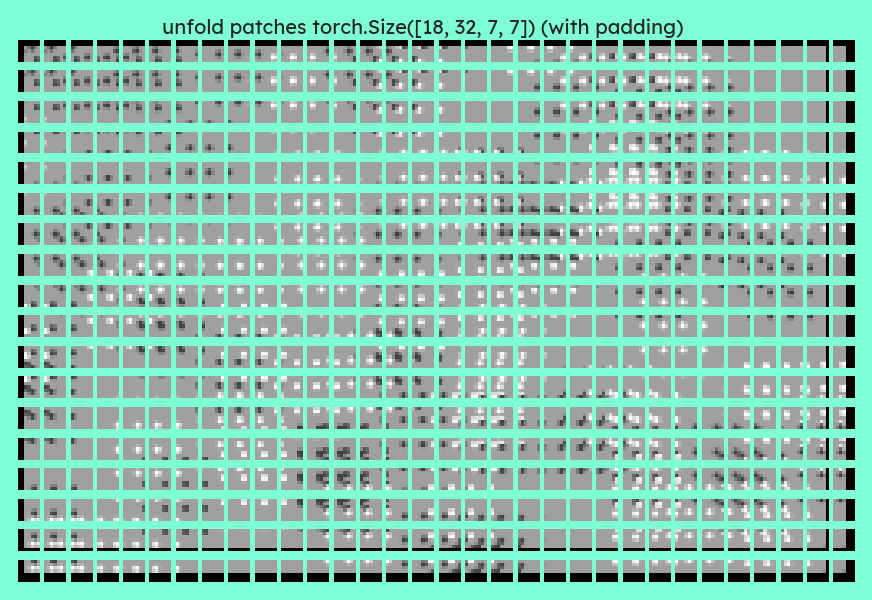

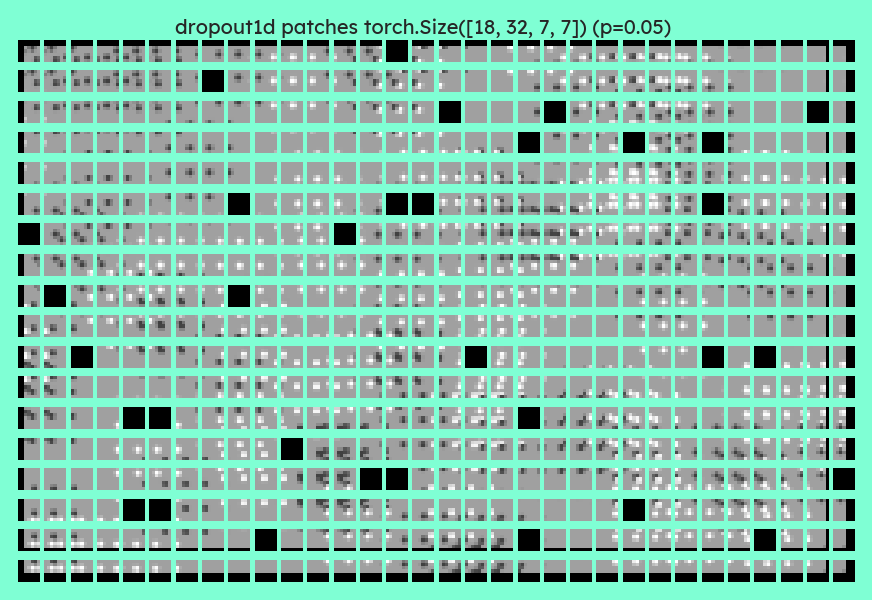

In [14]:
visualize_unfold("A", trial_id=161, patch_size=7, stride=2, p=0.05)

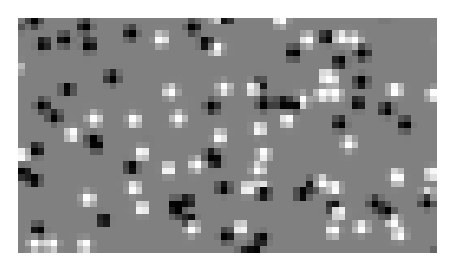

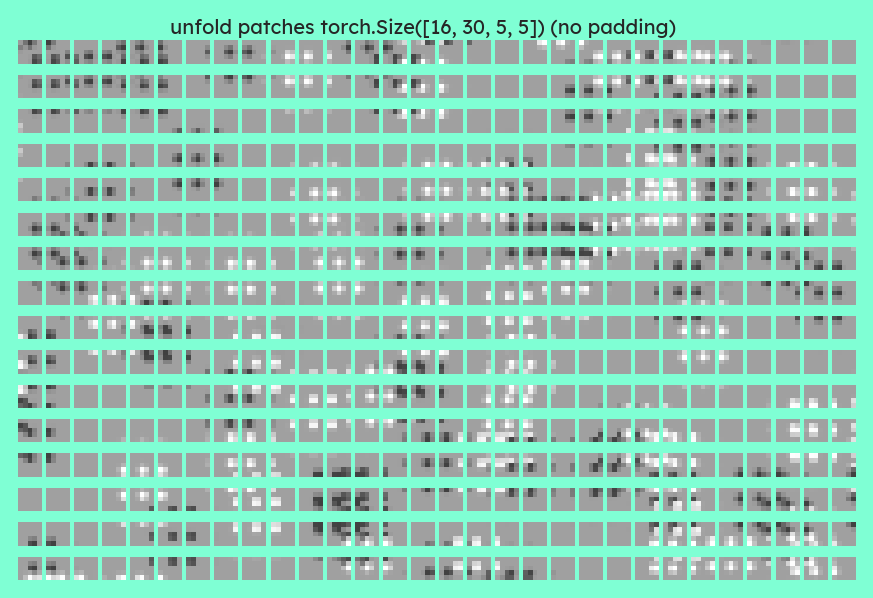

pad: (1, 2, 1, 2), frame shape: torch.Size([36, 64])
pad frame shape: torch.Size([1, 39, 67])


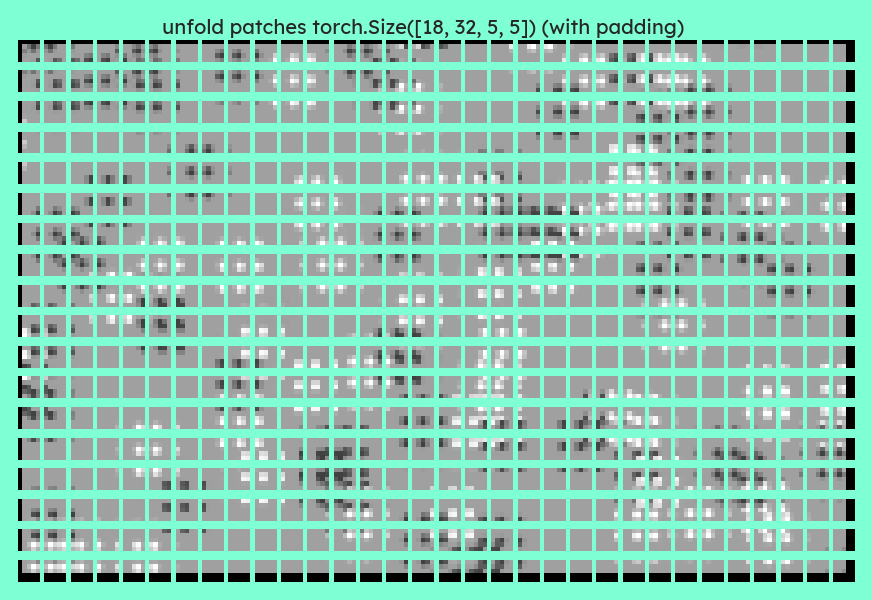

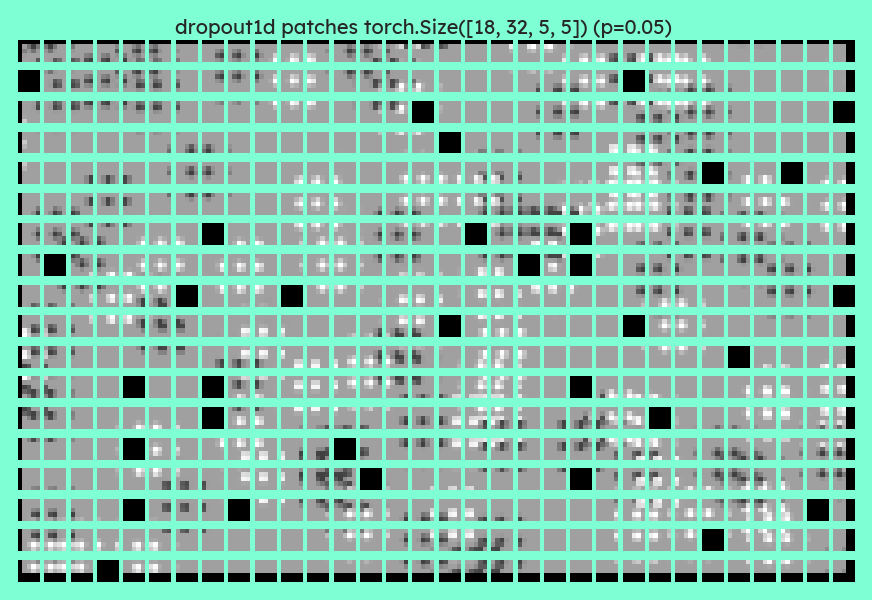

In [15]:
visualize_unfold("A", trial_id=161, patch_size=5, stride=2, p=0.05)

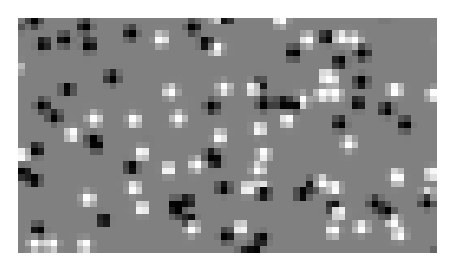

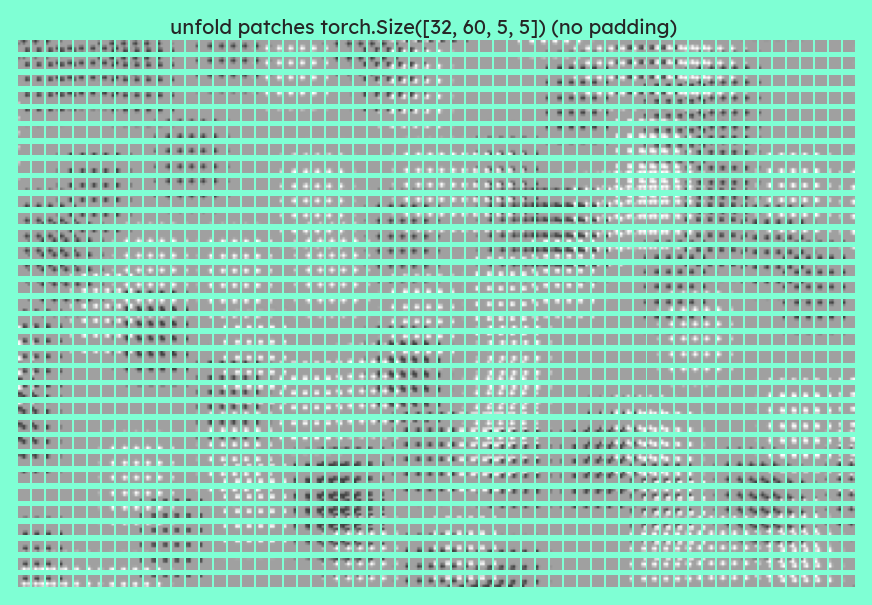

pad: (2, 2, 2, 2), frame shape: torch.Size([36, 64])
pad frame shape: torch.Size([1, 40, 68])


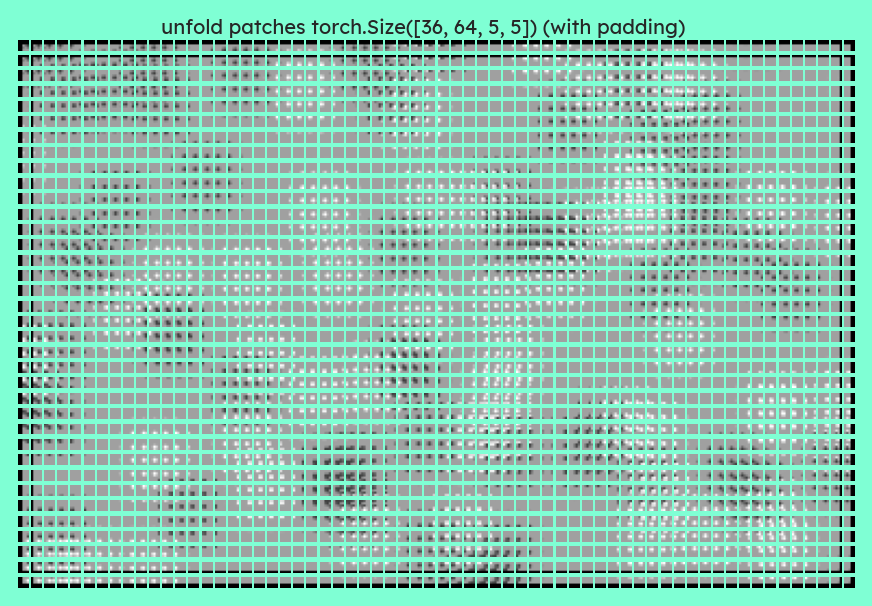

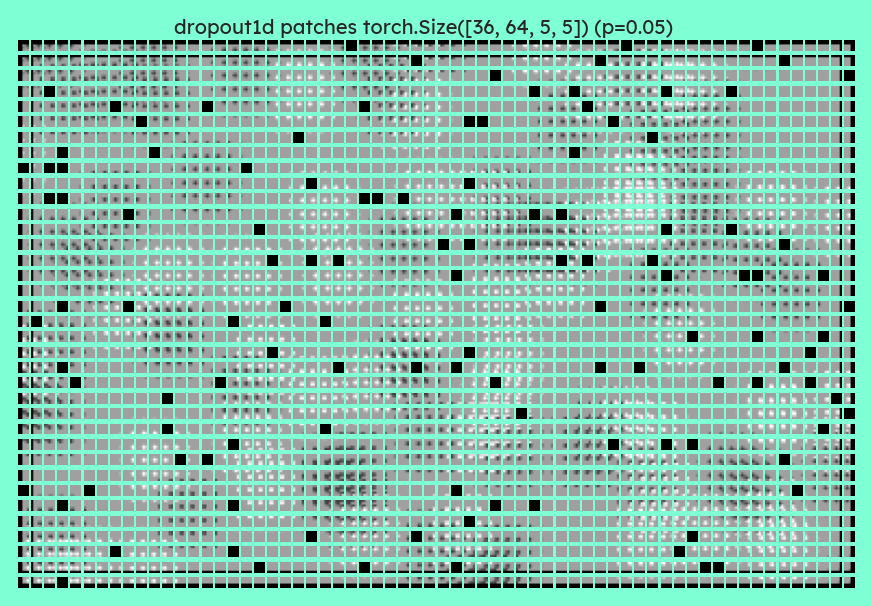

In [16]:
visualize_unfold("A", trial_id=161, patch_size=5, stride=1, p=0.05)

In [17]:
T = 300
time = torch.arange(T) + 1
patch_size, stride = 24, 1
t_pad = pad_size(T, patch_size, stride)
pad = (t_pad, 0)
time = F.pad(time, pad=pad, mode="constant", value=0)
time = time.unfold(0, patch_size, stride)
print(time.shape)
print(time)

torch.Size([300, 24])
tensor([[  0,   0,   0,  ...,   0,   0,   1],
        [  0,   0,   0,  ...,   0,   1,   2],
        [  0,   0,   0,  ...,   1,   2,   3],
        ...,
        [275, 276, 277,  ..., 296, 297, 298],
        [276, 277, 278,  ..., 297, 298, 299],
        [277, 278, 279,  ..., 298, 299, 300]])


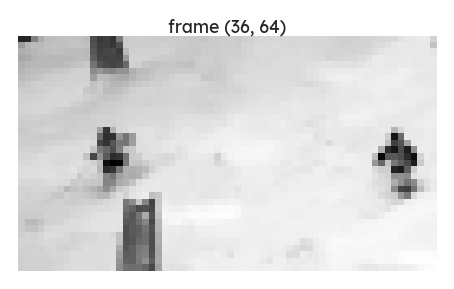

pad: (2, 3, 2, 3), frame shape: torch.Size([36, 64])
pad frame shape: torch.Size([1, 41, 69])


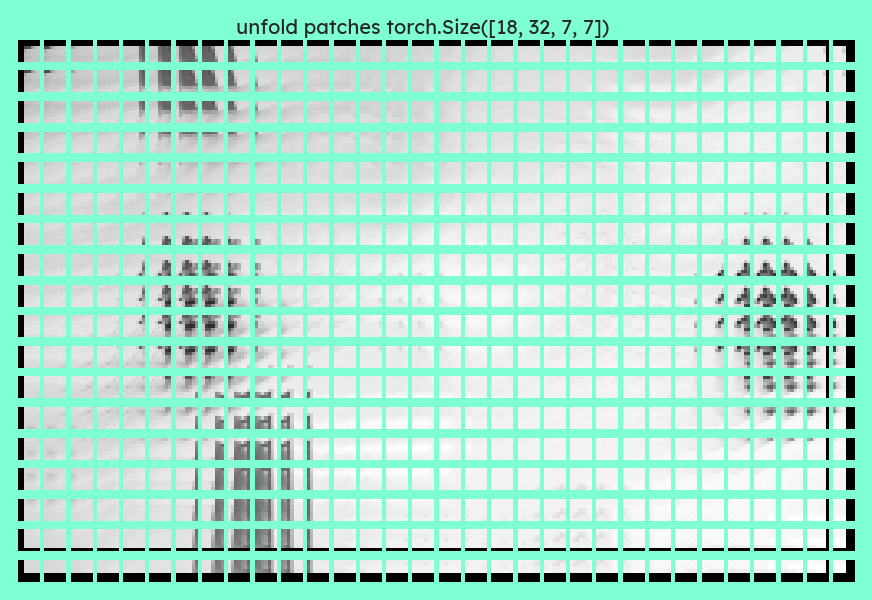

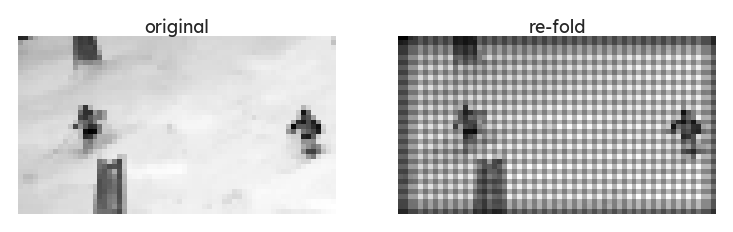

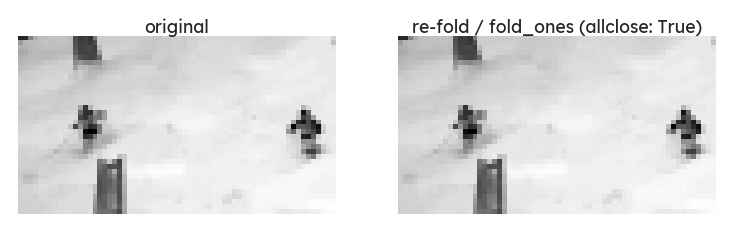

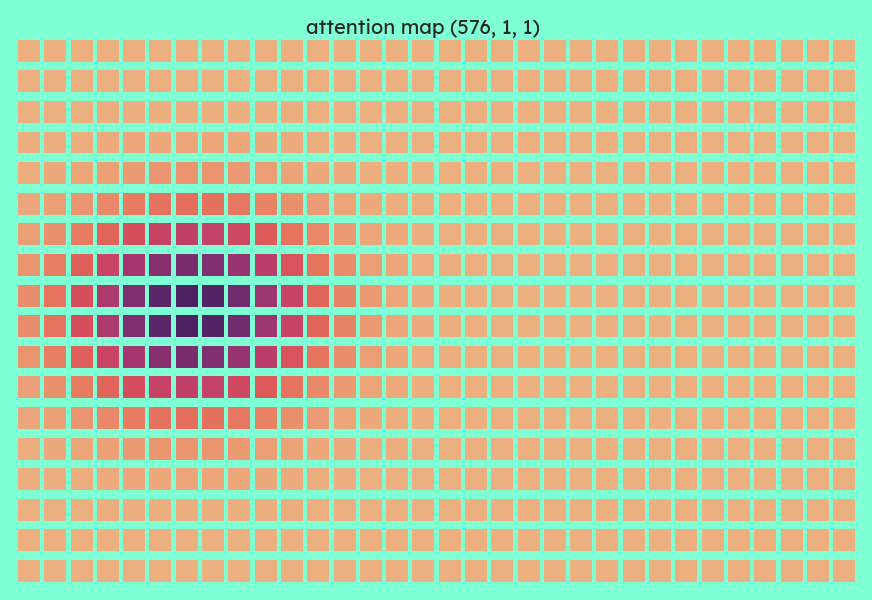

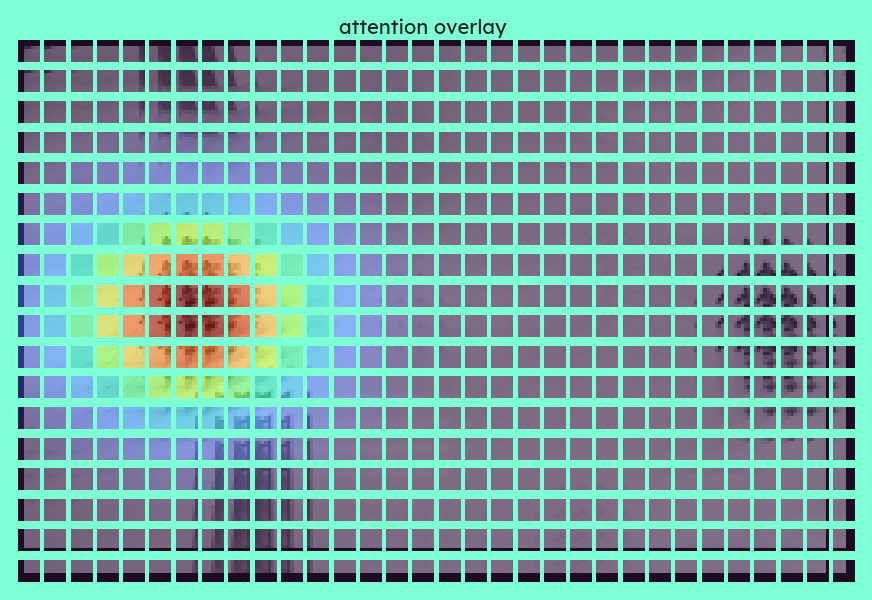

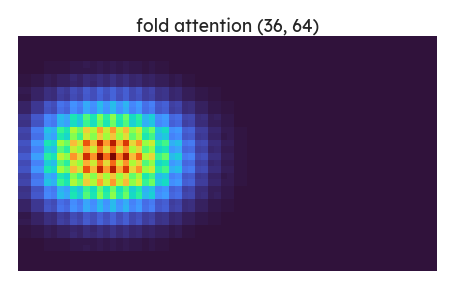

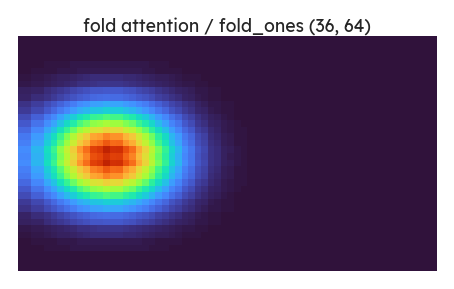

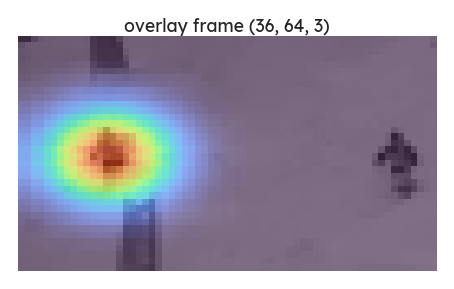

In [29]:
def fold(
    patches: np.ndarray,
    patch_size: int,
    stride: int,
    shape: Tuple[int, int],
    padding: Tuple[int, int, int, int],
):
    patches = torch.from_numpy(patches)
    if patches.size(1) == patches.size(2) == 1:
        patches = repeat(patches, "n 1 1 -> n ph pw", ph=patch_size, pw=patch_size)
    patches = rearrange(patches, "n ph pw -> 1 (ph pw) n")
    shape = (shape[0] + padding[2] + padding[3], shape[1] + padding[0] + padding[1])
    frame = F.fold(
        patches,
        output_size=shape,
        kernel_size=patch_size,
        stride=stride,
    )
    frame = frame[:, :, padding[2] : -padding[3], padding[0] : -padding[1]]
    frame = frame.numpy()
    return frame


def gaussian2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return (
        1.0
        / (2.0 * np.pi * sx * sy)
        * np.exp(
            -((x - mx) ** 2.0 / (2.0 * sx**2.0) + (y - my) ** 2.0 / (2.0 * sy**2.0))
        )
    )


def get_attention(width: int, height: int):
    x = np.linspace(0, width, width)
    y = np.linspace(0, height, height)
    x, y = np.meshgrid(x, y)  # get 2D variables instead of 1D
    return gaussian2d(x, y, mx=0.2 * width, my=height / 2, sx=width / 10, sy=height / 8)


def visualize_fold(mouse_id: str, trial_id: str | int):
    frame = load_frame(mouse_id, trial_id, t=25)
    frame = frame / np.max(frame)

    patch_size, stride = 7, 2

    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(frame, cmap="gray")
    ax.axis("off")
    ax.set_title(f"frame {frame.shape}", fontsize=7, pad=0)
    plt.show()
    plt.close(figure)

    unfold_patches, shape, padding = unfold(
        frame, patch_size=patch_size, stride=stride, pad=True
    )
    plot_patches(unfold_patches, shape, title=f"unfold patches {shape}")

    # plot re-fold reconstruction
    fold_patches = fold(
        unfold_patches,
        patch_size=patch_size,
        stride=stride,
        shape=(H, W),
        padding=padding,
    )
    fold_patches = rearrange(fold_patches, "1 1 h w -> h w")
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3), dpi=DPI)
    axes[0].imshow(frame, cmap="gray")
    axes[1].imshow(fold_patches, cmap="gray")
    axes[0].set_title("original", fontsize=7, pad=0)
    axes[1].set_title("re-fold", fontsize=7, pad=0)
    axes[0].axis("off")
    axes[1].axis("off")
    plt.show()
    plt.close(figure)

    # plot re-fold reconstruction normalized by fold_one
    fold_patch_ones = fold(
        np.ones_like(unfold_patches),
        patch_size=patch_size,
        stride=stride,
        shape=(H, W),
        padding=padding,
    )
    fold_patches2 = fold_patches / fold_patch_ones
    fold_patches2 = rearrange(fold_patches2, "1 1 h w -> h w")
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3), dpi=DPI)
    axes[0].imshow(frame, cmap="gray")
    axes[1].imshow(fold_patches2, cmap="gray")
    axes[0].set_title("original", fontsize=7, pad=0)
    axes[1].set_title(
        f"re-fold / fold_ones (allclose: {np.allclose(frame, fold_patches2)})",
        fontsize=7,
        pad=0,
    )
    axes[0].axis("off")
    axes[1].axis("off")
    plt.show()
    plt.close(figure)

    # generate random attention map
    attention_map = get_attention(width=shape[1], height=shape[0])
    attention_map = attention_map / np.max(attention_map)
    attention_map = rearrange(attention_map, "h w -> (h w) 1 1")
    plot_patches(
        attention_map,
        shape=(shape[0], shape[1]),
        title=f"attention map {attention_map.shape}",
        cmap="flare",
    )

    alpha = 0.6
    turbo = matplotlib.colormaps["turbo"]
    turbo_color = turbo(np.arange(256))[:, :3]
    # apply attention to patches
    heatmap = turbo_color[np.uint8(255.0 * attention_map)]
    overlay = alpha * heatmap + (1 - alpha) * unfold_patches[..., None]
    plot_patches(overlay, shape, title=f"attention overlay", cmap=turbo)

    fold_attention = fold(
        attention_map,
        patch_size=patch_size,
        stride=stride,
        shape=(H, W),
        padding=padding,
    )
    fold_attention1 = fold_attention / np.max(fold_attention)
    fold_attention1 = rearrange(fold_attention1, "1 1 h w -> h w")

    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(fold_attention1, cmap=turbo, vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"fold attention {fold_attention1.shape}", fontsize=7, pad=0)
    plt.show()
    plt.close(figure)

    fold_ones = fold(
        np.ones_like(attention_map),
        patch_size=patch_size,
        stride=stride,
        shape=(H, W),
        padding=padding,
    )
    fold_attention2 = fold_attention / fold_ones
    fold_attention2 = rearrange(fold_attention2, "1 1 h w -> h w")

    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(fold_attention2, cmap=turbo, vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(
        f"fold attention / fold_ones {fold_attention2.shape}", fontsize=7, pad=0
    )
    plt.show()
    plt.close(figure)

    heatmap = turbo_color[np.uint8(255.0 * fold_attention2)]
    overlay = alpha * heatmap + (1 - alpha) * frame[..., None]
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(overlay, cmap=turbo, vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"overlay frame {overlay.shape}", fontsize=7, pad=0)
    plt.show()
    plt.close(figure)


visualize_fold("A", trial_id=154)